## Introduction ##

This notebook is designed to simulate the general layer percolation process. 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Simulation ##

In [2]:
#Function for offsetting shape associated to each cell
def get_offsets(right_offset, cell, shape):
    offset_cells = []
    for shape_cell in shape:
        #For each cell in the shape, take the right coordinate from the shape, take the sleep coordinate from both the shape and the cell
        offset_cells.append(tuple(np.array([shape_cell[0], shape_cell[1]])+np.array([right_offset, cell[1]])))
    return offset_cells

In [3]:
#Function to determine the width of a shape
def width(shape):
    width = 0
    for cell in shape:
        if cell[0] > width:
            width = cell[0]
    return width+1

In [4]:
#This function takes in an unordered array of cells and partitions it into an array of diagonals. 
def partition_into_layers(newly_invaded_cells):
    flat_list = []
    num_layers = 0
    for list in newly_invaded_cells:
        for element in list:
            #Find the largest layer in the set of newly invaded cells
            if element[0]+element[1] > num_layers:
                num_layers = element[0]+element[1]
            flat_list.append(element)

    invaded_layers = []
    
    for layer in range(num_layers+1):
        layer_i = []
        for cell in flat_list:
            #Only add a cell if it's not already in the layer, so we are not keeping repeat cells
            if cell[0]+cell[1] == layer and (cell[0], cell[1]) not in layer_i:
                layer_i.append((cell[0], cell[1]))
        invaded_layers.append(layer_i)   
    return invaded_layers

In [5]:
#This function specifies a law used to generate shapes. 
#The default law is the comb percolation law. 
#Use mode custom to implement a custom law. Note if you require more dependency between shapes than that of comb percolation
#you will need to refactor this code. 
def law(sleep_rate, inheritance_indicator, mode ='comb'):
    match mode:
        case 'one':
            shape = one_law()
        case 'domino':
            shape = domino_law()
        case 'interval':
            shape = interval_law(sleep_rate)
        case 'comb':
            [shape, new_inheritance_indicator] = comb_law(sleep_rate, inheritance_indicator)
        case 'custom':
            shape = custom_law()

    if mode != 'comb':
        new_inheritance_indicator = inheritance_indicator

    return [shape, new_inheritance_indicator]

In [6]:
def one_law():
    shape = [(0,0),(1,0),(2,0),(1,1),(1,2),(0,2)]
    return shape

In [7]:
def domino_law():
    if random.getrandbits(1):
        shape = [(0,0), (1,0)]
    else:
        shape = [(0,0),(0,1)]
    return shape

In [8]:
def interval_law(sleep_rate):
    shape = []
    R = np.random.geometric(1/2) #np geometric is supported on {1,2,...}, so no need to add 1 here.
    for i in range(R):
        shape.append((i,0))
        if np.random.rand() < sleep_rate/(1+sleep_rate):
            shape.append((i,1))
    return shape

In [9]:
def comb_law(sleep_rate, inheritance_indicator):
    shape = []
    U = np.random.geometric(1/2) #np geometric is supported on {1,2,...}, so no need to add 1 here.
    r_counter = 0
    for i in range(U):
        R_i = np.random.geometric(2/3) #np geometric is supported on {1,2,...}, so no need to add 1 here.
        if i == 0:
            T = inheritance_indicator
        else:
            if np.random.rand() < sleep_rate/(1+sleep_rate):
                T = 1
            else:
                T = 0
    
        for j in range(R_i):
            s = np.random.rand()
            if s < sleep_rate/(1+sleep_rate):
                S = 1
            else:
                S = 0
            #Don't want repeat cells added to the shape for performance. 
            for tuple in {(r_counter, 0), (r_counter, S), (r_counter, T), (r_counter, S+T)}:
                if tuple not in shape:
                    shape.append(tuple)
            r_counter += 1
        r_counter -= 1 #We overcounted the number of rights executed. 
                
    new_inheritance_indicator = T
    return [shape, new_inheritance_indicator]

In [10]:
#Modify this function if you want to simulate a custom law. 
def custom_law():
    shape = [(0,0)]
    return shape

In [11]:
#This function takes in a set of invaded cells separated into diagonals and a sleep rate, 
#and returns an array of newly invaded cells after one step of the layer percolation process. 
#The returned array of newly invaded cells is separated into diagonals already
def run_layer_percolation_step(invaded_cells, sleep_rate, mode = 'comb'):
    newly_invaded_cells = []
    #Assumes invaded_cells is an array of diagonals containing cells
    num_layers = len(invaded_cells)
    shape_array = []
    right_offset = 0
    if mode == 'comb':
        if np.random.rand() < sleep_rate/(1+sleep_rate):
            inheritance_indicator = 1
        else:
            inheritance_indicator = 0
    else:
        inheritance_indicator = None
    for i in range(num_layers):
        #For each diagonal, generate a shape from the law
        [shape_i, inheritance_indicator] = law(sleep_rate, inheritance_indicator, mode)
        #Add it to the list of shapes
        shape_array.append(shape_i)
    for i, diagonal in enumerate(invaded_cells):
        shape_i = shape_array[i]
        for cell in diagonal:
            offset_cells = get_offsets(right_offset, cell, shape_i)
            newly_invaded_cells.append(offset_cells)
        #Layers are formed with overlap of 1
        right_offset += width(shape_i)-1
    newly_invaded_cells = partition_into_layers(newly_invaded_cells)
    return newly_invaded_cells

## Running Simulations ## 

In [12]:
#Parameters
num_iterations = 20
sleep_rate = 0.5

#Begin with the origin invaded, double [[]] as this is an array of diagonals (which are arrays of cells in the diagonal)
invaded_cells = partition_into_layers([[(0,0)]])
for i in range(num_iterations):
    print("Iteration: "+str(i+1), end="\r")
    #Change the mode to 'custom' if you have implemented a custom law. Other options are 'one', 'domino' and 'interval'. 
    #The default with no input is comb.
    invaded_cells = run_layer_percolation_step(invaded_cells, sleep_rate, mode = 'comb')

## Plotting ##

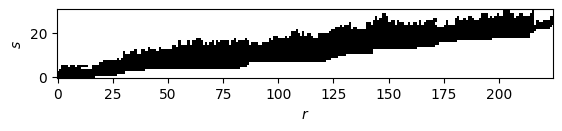

In [13]:
# Formatting, the invaded_cells array is a list of diagonals, so we are unwrapping this into just coordinates
points = [pt for diag in invaded_cells for pt in diag]

# Find max x and y to size the array
max_x = max(p[0] for p in points)
max_y = max(p[1] for p in points)

# Create 2D numpy array with ones
pixel_array = np.ones((max_y + 1, max_x + 1))  # shape = (rows=y, cols=x)

# Fill array at each coordinate with 0, want filled cells to be black and empty cells to be white
for x, y in points:
    pixel_array[y, x] = 0  # Note: y is row, x is column

plt.figure()
plt.imshow(pixel_array, cmap='gray', interpolation='nearest', origin='lower')
plt.xlabel("$r$")
plt.ylabel("$s$")
#plt.savefig('LayerPercolationPlot.png', bbox_inches='tight', dpi=300)
plt.show()